In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize': (12, 6)})

# Real world examples of forecasting - wave height

In [5]:
df = pd.read_csv("data\\waves_mod.csv", engine="python")
df.head()

,Hsig,RTpeak,PkDir,Hsig_distanced
0,0.03720,2.0523,45.0,0.022798
1,0.02223,2.0523,25.0,0.016980
2,0.01635,2.0523,105.0,0.017811
3,0.01694,2.0523,265.0,0.023283
4,0.02338,2.0523,265.0,0.034474


Number of parts: 4 
  Means: 0.168142 0.122553 0.139667 0.268130 
  Variances: 0.006174 0.003317 0.006474 0.036738 


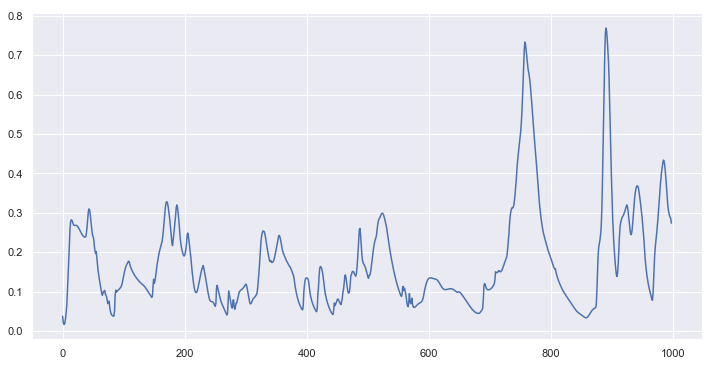

In [6]:
variable=df['Hsig']
plt.plot(variable)

def stationarity(var, parts_num):
    part_len = len(var) // parts_num
    means = []
    variances = []
    for i in range(parts_num):
        means.append(var[part_len * i : part_len * (i + 1)].mean())
        variances.append(var[part_len * i : part_len * (i + 1)].var())
        
    print('Number of parts: %i \n  Means: ' % (parts_num), end='')
    for i in means:
        print('%5f' %(i), end=' ')
    print('\n  Variances: ', end='')
    for i in variances:
        print('%5f' %(i), end=' ')
    print()

stationarity(variable, 4)   

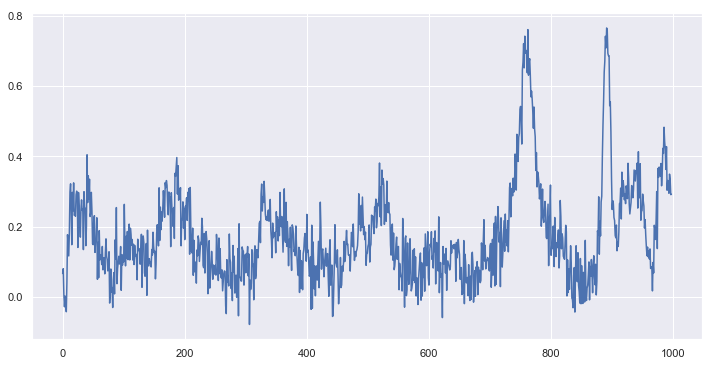

In [7]:
variable = variable + np.random.normal(0,0.05,len(variable))
plt.plot(variable)

<Figure size 1152x432 with 0 Axes>

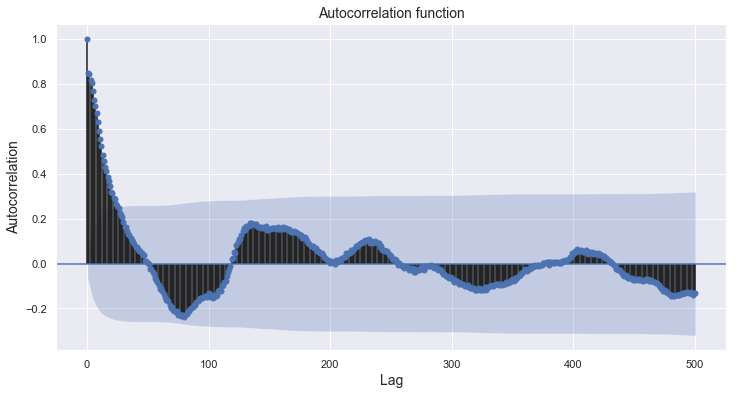

In [8]:
def covariance(X, Y, tau):
    if type(tau) == np.ndarray:
        res = np.zeros(len(tau))
        for i, v in enumerate(tau):
            res[i] = ((X[:(-v if v else len(X))] - X.mean()).values * (Y[v:] - Y.mean()).values).sum() / (X.shape[0] - v)
        return res
    return ((X[:(-tau if tau else len(X))] - X.mean()).values * (Y[tau:] - Y.mean()).values).sum() / (X.shape[0] - tau)
    
def correlation(X, Y, tau):
    return covariance(X, Y, tau) / (X.std() * Y.std())

from statsmodels.graphics.tsaplots import plot_acf

num_lags = 500
lags = np.arange(0, num_lags+1)

corrs = correlation(variable, variable, lags)

plt.figure(figsize=(16, 6))
plot_acf(variable.values, lags=num_lags)
#plt.plot(lags, corrs)
plt.title('Autocorrelation function', fontsize=14)
plt.xlabel('Lag', fontsize=14)
plt.ylabel('Autocorrelation', fontsize=14);



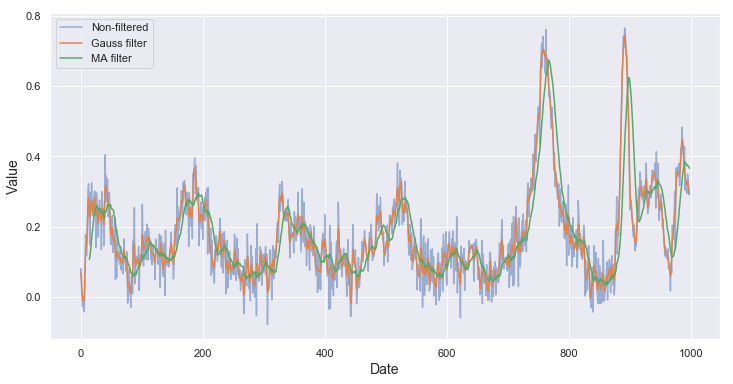

In [9]:
from scipy.ndimage import gaussian_filter

variable_roll = variable.rolling(window=15).mean().iloc[15-1:]
variable_gauss = gaussian_filter(variable, sigma=1)

fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(variable.index, variable, alpha=0.5, label="Non-filtered")
ax.plot(variable.index, variable_gauss, label="Gauss filter")
ax.plot(variable.index[14:], variable_roll.values, label="MA filter")
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend()
plt.show()

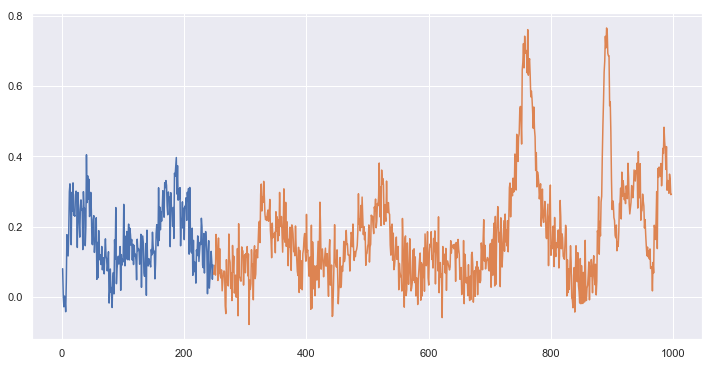

In [10]:
from statsmodels.tsa.ar_model import AR

from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import mean_absolute_error
test_size = 750

train, test = variable[1:len(variable)-test_size], variable[len(variable)-test_size:]
test = test
train = train

plt.plot(train)
plt.plot(test)

In [11]:
model = AR(train.values)
model_fit = model.fit(trend='nc')
window = model_fit.k_ar
coef = model_fit.params

test_real = test

#test = test - test

print('Lag: %s' % model_fit.k_ar)

history = train[len(train)-window:]
history = list(history.values)
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = 0
    for d in range(window):
        yhat += coef[d] * lag[window-d-1]
    obs = test_real[test_real.index[t]]
    predictions.append(yhat)
    history.append(obs)
    
mse = mean_absolute_error(test_real, predictions)
print('Test MAE: %.7f' % mse)

Lag: 15
Test MAE: 0.0522773


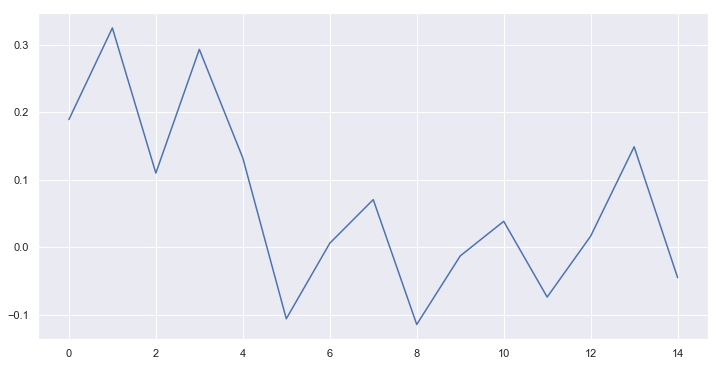

In [12]:
plt.plot(coef)

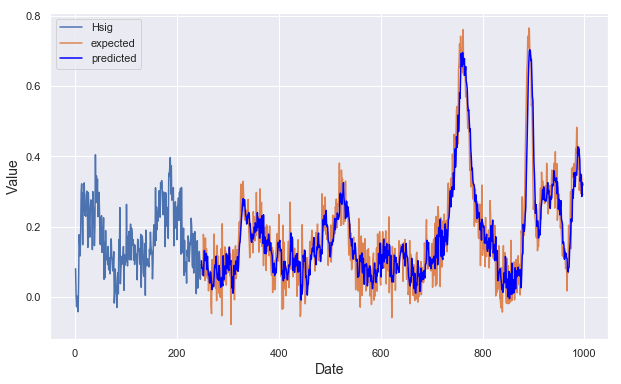

In [13]:
plt.figure(figsize=(10,6))
plt.plot(train)
plt.plot(test.index, test, label="expected")
plt.plot(test.index, predictions, color='blue', label="predicted")
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend()
plt.show()

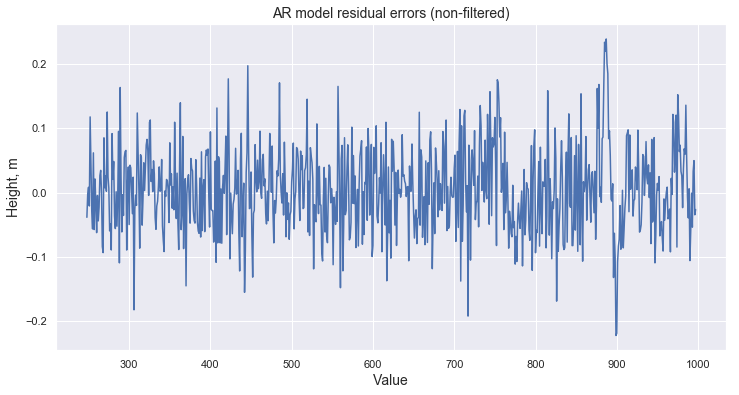

In [14]:
residuals = pd.Series(test - predictions)
plt.plot(residuals)
plt.title('AR model residual errors (non-filtered)', fontsize=14)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Height, m', fontsize=14);

# Dynamic modelling

In [15]:
from statsmodels.tsa.vector_ar.var_model import VAR

train, test = df[['Hsig', 'RTpeak','PkDir','Hsig_distanced']][:-test_size], df[['Hsig', 'RTpeak','PkDir','Hsig_distanced']][-test_size:]

history = train
predictions = list()

for t in range(test.shape[0]):
    model = VAR(endog=history)
    model_fit = model.fit(maxlags=16)
    output = model_fit.forecast(model_fit.y, steps=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t]
    history = history.append(obs)

pred = pd.DataFrame(index=range(0,len(predictions)),columns=['Hsig', 'RTpeak','PkDir'])
for j in range(2):
    for i in range(0, len(predictions)):
        pred.iloc[i][j] = predictions[i][j]
        
for i in ['Hsig', 'RTpeak']:
    print('MAE value for %s is : %7f' 
          % (i, mean_absolute_error(pred[i], test[i])))

D:\Anaconda3\lib\site-packages\statsmodels\base\wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


MAE value for Hsig is : 0.000862
MAE value for RTpeak is : 0.243947


# Mutal correlation

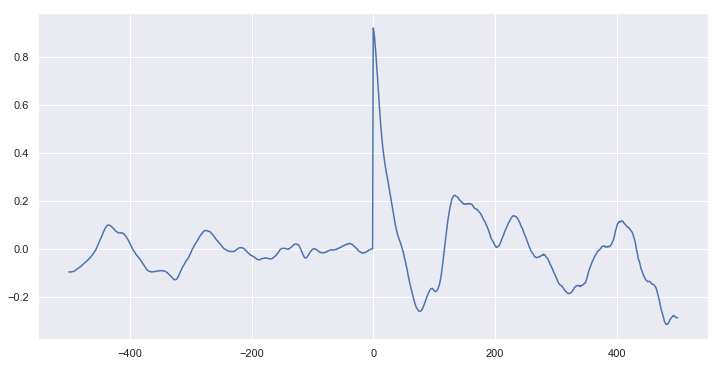

In [16]:
y=np.append(correlation(variable, df['Hsig_distanced'], -lags[:0:-1]), correlation(variable, df['Hsig_distanced'], lags))
x=np.append(-lags[:0:-1], lags)

plt.plot(x, y)


#try RTpeak, PkDir, Hsig_distanced

# Prediction of additional variable

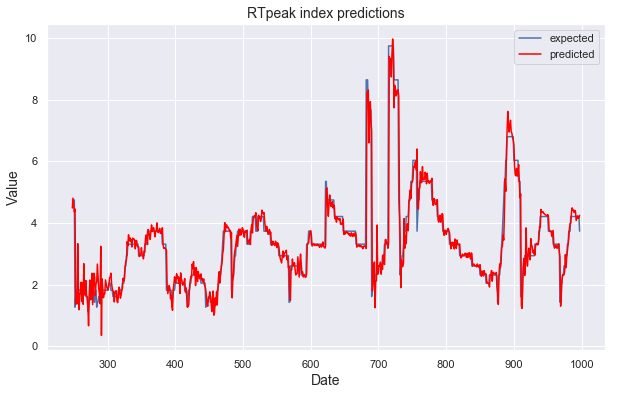

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['RTpeak'], label="expected")
plt.plot(test.index, pred['RTpeak'], color='red', label="predicted")
plt.title('RTpeak index predictions', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend()
plt.show()

# One-step prediction of HSig

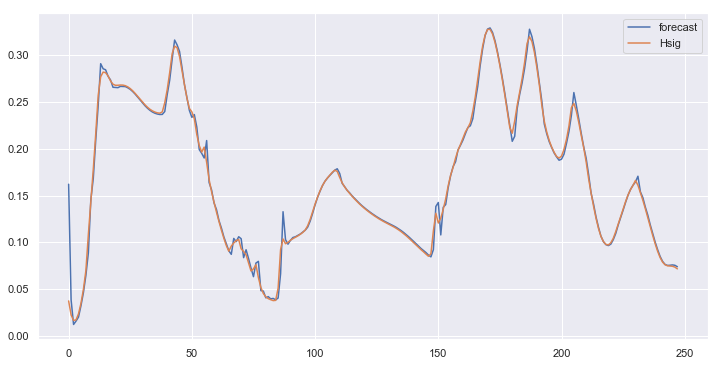

In [18]:
from statsmodels.tsa.arima_model import ARIMA

fitted_model = ARIMA(train['Hsig'], order=(3,0,1),).fit(disp=0)
fitted_model.plot_predict(dynamic=False)
plt.show()

# Multi-step forecasting

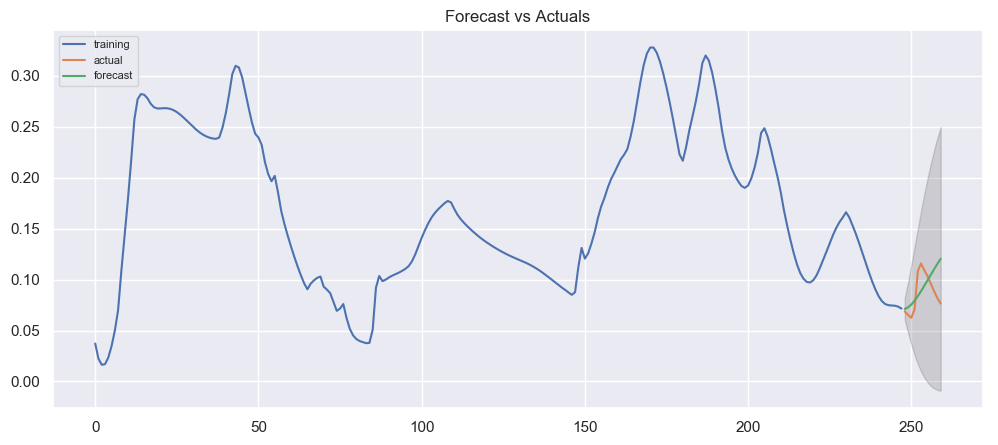

In [22]:
from statsmodels.tsa.arima_model import ARIMA

fitted_model = ARIMA(train['Hsig'], order=(3,0,1)).fit(disp=0)

fc_size=12
fc, se, conf = fitted_model.forecast(fc_size, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=test.index[0:fc_size])
lower_series = pd.Series(conf[:, 0], index=test.index[0:fc_size])
upper_series = pd.Series(conf[:, 1], index=test.index[0:fc_size])

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['Hsig'], label='training')
plt.plot(test['Hsig'][0:fc_size], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Multi-step forecasting with exogenous variable

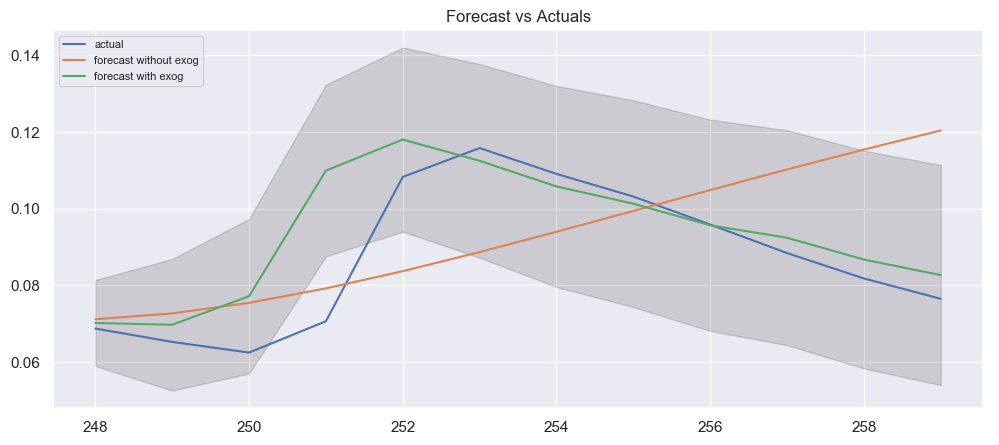

In [23]:
fitted_model_exog = ARIMA(train['Hsig'], order=(3,0,1), exog=train['Hsig_distanced']).fit(disp=0)

fc_size=12
fc_exog, se, conf = fitted_model_exog.forecast(fc_size, alpha=0.05, exog=test['Hsig_distanced'][0:fc_size])

fc_series = pd.Series(fc, index=test.index[0:fc_size])
fc_exog_series = pd.Series(fc_exog, index=test.index[0:fc_size])
lower_series = pd.Series(conf[:, 0], index=test.index[0:fc_size])
upper_series = pd.Series(conf[:, 1], index=test.index[0:fc_size])

plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train['Hsig'], label='training')
plt.plot(test['Hsig'][0:fc_size], label='actual')
plt.plot(fc_series, label='forecast without exog')
plt.plot(fc_exog_series, label='forecast with exog')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Multi-step forecasting for the dynamical system

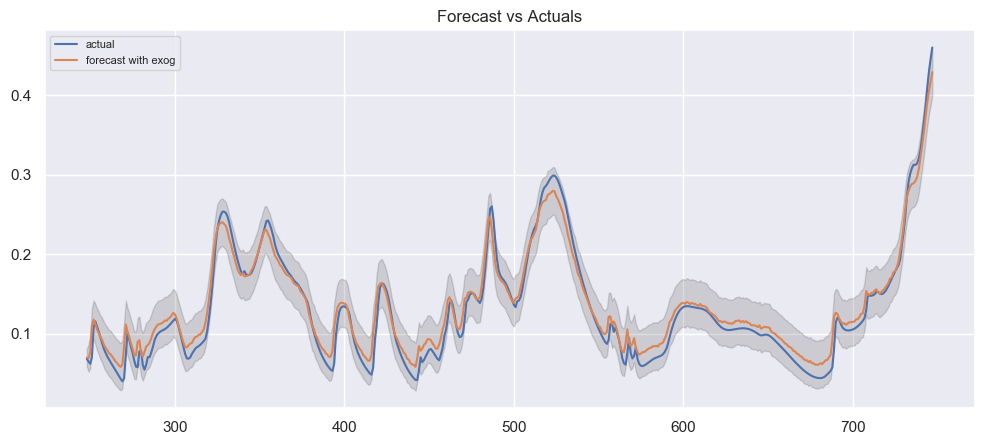

In [24]:
fc_size=500
fc_exog, se, conf = fitted_model_exog.forecast(fc_size, alpha=0.05, exog=test['Hsig_distanced'][0:fc_size])

fc_exog_series = pd.Series(fc_exog, index=test.index[0:fc_size])
lower_series = pd.Series(conf[:, 0], index=test.index[0:fc_size])
upper_series = pd.Series(conf[:, 1], index=test.index[0:fc_size])

plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train['Hsig'], label='training')
plt.plot(test['Hsig'][0:fc_size], label='actual')
plt.plot(fc_exog_series, label='forecast with exog')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()